<a href="https://colab.research.google.com/github/nitsansoffair/IK/blob/main/IK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount.

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset.

In [2]:
import torch
import zipfile
import os
import cv2

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from torchvision.models.video import r3d_18
from torch.utils.data import DataLoader, random_split
from fastai.vision.all import *
from pathlib import Path

# Extract the ZIP file
zip_path = "/content/drive/MyDrive/PhD/BGU/BigData/Project/IK.zip"
extract_path = "/content/videos"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define paths for video folders
politicians_path = Path(extract_path) / "politicians"
idealists_path = Path(extract_path) / "idialists"

Hyperparameters.

In [3]:
# Video frames.
n_frames = 1

# Frame index start.
frame_idx_s = 10

# Training epochs.
n_epochs = 1_000

# Report frequency.
report_freq = 100

Model.

In [4]:
import torch
import cv2

import numpy as np

from torch.utils.data import Dataset
from pathlib import Path

class VideoDataset(Dataset):
    def __init__(self, video_dir, label, n_frames, frame_idx_s):
        self.video_dir = Path(video_dir)
        self.label = label
        self.video_files = list(self.video_dir.glob("*.mp4"))

        self.n_frames = n_frames
        self.frame_idx_s = frame_idx_s

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = str(self.video_files[idx])
        cap = cv2.VideoCapture(video_path)
        frames = []

        idx_frame = 0

        while True:
            ret, frame = cap.read()

            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))  # Ensure consistent size
            frames.append(frame)

            if idx_frame - self.frame_idx_s == self.n_frames:
                break

            idx_frame += 1

        cap.release()

        frames = frames[self.frame_idx_s:self.frame_idx_s + self.n_frames]

        frames = np.stack(frames)
        frames = torch.tensor(frames, dtype=torch.float32).permute(3, 0, 1, 2)  # Convert to (C, T, H, W)

        return frames, self.label

Split.

In [5]:
# Prepare datasets
politicians_dataset = VideoDataset(politicians_path, 0, n_frames, frame_idx_s)
idealists_dataset = VideoDataset(idealists_path, 1, n_frames, frame_idx_s)

full_dataset = torch.utils.data.ConcatDataset([politicians_dataset, idealists_dataset])

# Split dataset into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoader with a custom collate function
def collate_fn(batch):
    videos, labels = zip(*batch)

    # Pad all videos to have the same number of frames
    padded_videos = []

    for video in videos:
        padded_videos.append(video)

    videos_tensor = torch.stack(padded_videos)
    labels_tensor = torch.tensor(labels)

    return videos_tensor, labels_tensor

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

Features.

In [6]:
# Use a pretrained R3D model for feature extraction
model = r3d_18(pretrained=True).cuda()
model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust for 2 classes

# Loss and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 159MB/s]


Train.

In [7]:
for epoch in range(n_epochs):
    model.train().cuda()
    loss_epoch = 0

    for videos, labels in train_loader:
        # Ensure videos and labels are on the correct device
        videos, labels = videos.cuda(), labels.cuda()

        # Forward pass
        outputs = model(videos)

        # Compute loss
        loss = criterion(outputs.cuda(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()

    if epoch % report_freq == 0:
        print(f"Epoch {epoch+1}, Loss: {loss_epoch:.2f}")

Epoch 1, Loss: 9.09
Epoch 101, Loss: 0.40
Epoch 201, Loss: 0.00
Epoch 301, Loss: 0.00
Epoch 401, Loss: 0.00
Epoch 501, Loss: 0.00
Epoch 601, Loss: 0.00
Epoch 701, Loss: 0.00
Epoch 801, Loss: 0.00
Epoch 901, Loss: 0.00


Evaluate.

In [8]:
# Evaluation
def evaluate(model, test_loader):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for videos, labels in test_loader:
            videos, labels = videos.cuda(), labels.cuda()

            outputs = model(videos)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}%")

evaluate(model, test_loader)

Accuracy: 100.0%


Test.

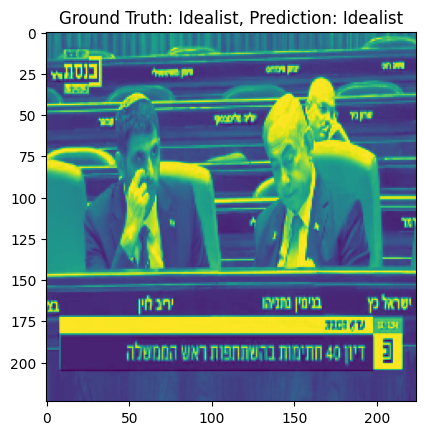

In [9]:
# Display a test example
def show_test_example(model, test_loader):
    model.eval()

    videos, labels = next(iter(test_loader))

    video = videos[0].cpu().numpy()
    label = labels[0].item()

    # Get the model's prediction
    with torch.no_grad():
        output = model(videos.cuda()[0].unsqueeze(0))
        predicted_label = torch.argmax(output, dim=1).item()

    # Display the first frame of the video
    plt.imshow(np.transpose(video[0], (1, 2, 0)))
    plt.title(f"Ground Truth: {'Politician' if label == 0 else 'Idealist'}, Prediction: {'Politician' if predicted_label == 0 else 'Idealist'}")
    plt.show()

show_test_example(model, test_loader)